<a href="https://colab.research.google.com/github/i4ata/3BP/blob/main/DataGeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random as rd
import time
from tqdm import tqdm
import numba as nb

from google.colab import drive
drive.mount('/content/gdrive')

np.seterr(invalid = 'ignore')
#np.random.seed(1234)


Mounted at /content/gdrive


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [ ]:
step = 0.001
max_t = 5
M = [1,1,1]
G = 1
softening = 0.001
step_sq = step**2

t = np.arange(start = 0, stop = max_t, step = step)
t_short = t[:1000] # Reduce timesteps to only 1000

In [ ]:
def setup():
  return np.concatenate((
      np.random.normal(loc = 0., scale = 1.5, size = 6), # locations
      np.random.normal(loc = 0., scale = 0.5, size = 6)  # velocities
  ))

In [ ]:
def show(x, y):
  
  plt.figure(figsize = (8, 8))
  plt.plot(x[:,0], y[:,0], color = 'green')
  plt.plot(x[:,1], y[:,1], color = 'blue')
  plt.plot(x[:,2], y[:,2], color = 'red')
  plt.scatter(x[0][0], y[0][0], color = 'green')
  plt.scatter(x[0][1], y[0][1], color = 'blue')
  plt.scatter(x[0][2], y[0][2], color = 'red')
  plt.grid()
  plt.xlim(np.amin(x) - 0.2, np.amax(x) + 0.2)
  plt.ylim(np.amin(y) - 0.2, np.amax(y) + 0.2)
  
  plt.show()

In [ ]:
@nb.njit
def nan_to_num(arr):
    for i in range(arr.shape[0]):
        if np.isnan(arr[i]):
            arr[i] = 0
    return arr

In [ ]:
@nb.njit
def compute_acceleration(x, y, ax, ay, M = np.array([1,1,1]), G = 1, softening = .001):

    for i in range(3):

        dx = (x[i] - x).T
        dy = (y[i] - y).T

        d = np.sqrt(dx ** 2 + dy ** 2 + softening ** 2) ** 3
        
        ax[:, i] = nan_to_num(-dx*M*G / d)
        ay[:, i] = nan_to_num(-dy*M*G / d)

    ax_tot = np.sum(ax, axis=0)
    ay_tot = np.sum(ay, axis=0)

    return ax_tot, ay_tot

In [ ]:
def run_verlet(init = None):

  x = np.zeros(shape = (len(t) + 1, 3))
  y = np.zeros(shape = (len(t) + 1, 3))

  vx = np.zeros(shape = (len(t) + 1, 3))
  vy = np.zeros(shape = (len(t) + 1, 3))

  ax = np.zeros(shape = (3, 3))
  ay = np.zeros(shape = (3, 3))
  
  if init is None:
    init = setup()

  x[0] = init[:3]
  y[0] = init[3:6]

  vx[0] = init[6:9]
  vy[0] = init[9:]

  for i in range(len(t)):
    ax_tot, ay_tot = compute_acceleration(x[i], y[i], ax, ay)

    x[i+1] = x[i] + step * vx[i] + .5 * ax_tot * step_sq
    y[i+1] = y[i] + step * vy[i] + .5 * ay_tot * step_sq

    ax_tot_next, ay_tot_next = compute_acceleration(x[i+1], y[i+1], ax, ay)

    vx[i+1] = vx[i] + .5 * (ax_tot + ax_tot_next) * step
    vy[i+1] = vy[i] + .5 * (ay_tot + ay_tot_next) * step

    

  return x, y, vx, vy

In [ ]:
cool_setup = np.array([-0.48030582, -1.37429829, -1.28950245,  0.33897823,  
                       0.94316374, 0.27974152,  0.47623917,  0.49406879, 
                       -0.03630416, -0.27530146, -0.46907631, -0.61953578])

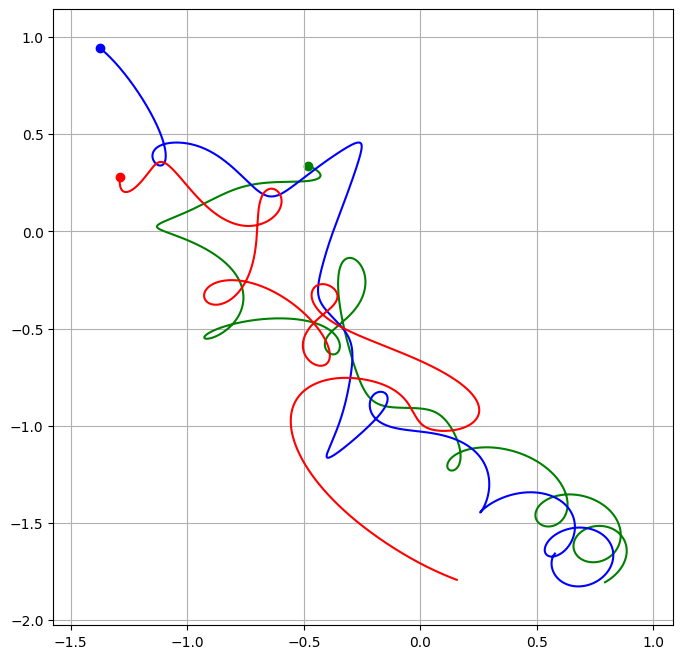

CPU times: user 5.26 s, sys: 228 ms, total: 5.49 s
Wall time: 7.21 s


In [ ]:
%%time
xs, ys, vxs, vys = run_verlet(init = cool_setup)
show(xs, ys)

In [ ]:
def generate_data(samples = 10_000):
  output = np.zeros((len(t) + 1, 12, samples))
  for sample in tqdm(range(samples)):
    output[:, :, sample] = np.concatenate(run_verlet(), axis = 1)
  return output

In [ ]:
def clean_data(a, threshold = 5):
  mask = (np.abs(a) < 5).all(axis = (0,1))
  return a[:, :, mask]

In [ ]:
#dat1 = generate_data() # this cell runs around 1.5 hrs on Colab GPU
#np.save("data1", clean_data(dat1))

In [ ]:
#dat2 = generate_data() # this cell runs around 1.5 hrs on Colab GPU
#np.save("data2", clean_data(dat2))

In [ ]:
dat3 = generate_data() # this cell runs around 1.5 hrs on Colab GPU
np.save("data3", clean_data(dat3))

100%|██████████| 10000/10000 [42:12<00:00,  3.95it/s]
